In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# Dataset, dataloader
import torch.utils.data as Data
from torchvision import transforms

# Model
import torch.nn as nn
import torch.nn.functional as F

# Training
from torch.autograd import Variable

# Progress bar
from tqdm import tqdm

# Save file
from datetime import date

# Confusion Matrix
import sklearn.metrics as skm

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Free memory checking
t = torch.cuda.get_device_properties(0).total_memory/1024/1024
r = torch.cuda.memory_reserved(0)/1024/1024
a = torch.cuda.memory_allocated(0)/1024/1024
f = r-a  # free inside reserved

print(f"Device Memory: {t}mb")
print(f"Reserved Memory: {r}mb")
print(f"Allocated Memory: {a}mb")
print(f"Free Memory: {f}mb")

Device Memory: 11263.6875mb
Reserved Memory: 0.0mb
Allocated Memory: 0.0mb
Free Memory: 0.0mb


In [4]:
# Use GPU
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [5]:
# Hyper Parameters
TRAIN_VAL_RATIO = 0.8
EPOCHS = 1
BATCH_SIZE = 2
LR = 0.001  

## Tasks to do
1. [Dataset](#1)
2. [Dataloader](#2)
3. [Model](#3)
4. [Training](#4)
5. [Evaluation](#5)

In [6]:
train = pd.read_csv("..\data/train_pivot.csv")
train

,ImageId,1,2,3,4
0,0002cc93b.jpg,True,False,False,False
1,0007a71bf.jpg,False,False,True,False
2,000a4bcdd.jpg,True,False,False,False
3,000f6bf48.jpg,False,False,False,True
4,0014fce06.jpg,False,False,True,False
...,...,...,...,...,...
6661,ffcf72ecf.jpg,False,False,True,False
6662,fff02e9c5.jpg,False,False,True,False
6663,fffe98443.jpg,False,False,True,False
6664,ffff4eaa8.jpg,False,False,True,False


## 1) Dataset<a class="anchor" id="1"></a>

In [7]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [8]:
class ImageDataset(Data.Dataset):
    def __init__(self, df, train=True):
        """
        Initialize a dataset as a list of IDs corresponding to each item of data set
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): filename of the csv file with annotations.
            train_test (string): Input 'train'/'test' to indicate the img folder
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.root_dir = os.path.join('..\data/', 'train_images/' if train==True else 'test_images/')

    def __len__(self):
        """
        Return the length of data set using list of IDs
        :return: number of samples in data set
        """
        return self.df.shape[0]

    def __getitem__(self, idx):
        """
        Generate one item of data set.
        :param index: index of item in IDs list
        :return: a sample of data as a dict
        """

        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Image
        img_name = os.path.join(self.root_dir, self.df.loc[idx, 'ImageId'])
        image = cv2.imread(img_name)
        
        # Transform image
        transform = transforms.Compose([
            transforms.ToTensor(),                          # Auto turn to range [0 1] in .ToTensor()
            transforms.Grayscale(num_output_channels=1),    # ToTensor first as .Grayscale() require tensor input
            #transforms.Resize([int(image.shape[0]),int(image.shape[0])]),   # resize make training faster
            transforms.RandomRotation(degrees=1),
            #transforms.Normalize(mean=[0.5], std=[0.5])    # Why 0.5? -> We will use BN at the beginning of the model instead
        ])
        
        # Label
        label = self.df.iloc[idx, 1:].values.astype(np.float)
        
        sample = {'image': transform(image),                # (1, 256, 1600), do not squeeze here as conv layer require 3D input
                  'label': torch.tensor(label).float()}       # sync label to float (pred from model will be make into float as well)
        return dotdict(sample)

tensor([[[0.0000, 0.0000, 0.4117,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3686,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2666,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2117, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2196, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2235, 0.0000, 0.0000]]])
image: torch.Size([1, 256, 1600])
torch.FloatTensor

tensor([1., 0., 0., 0.])
label: torch.Size([4])
torch.FloatTensor


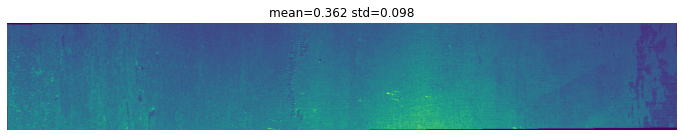

In [9]:
# testing: dataset
img_dataset = ImageDataset(train, train=True)

print(img_dataset[0].image)
print(f"image: {img_dataset[0].image.shape}")
print(img_dataset[0].image.type()+"\n")

mean = np.mean(img_dataset[0].image.detach().numpy().squeeze())
std = np.std(img_dataset[0].image.detach().numpy().squeeze())

plt.figure(figsize=(12,4))
plt.axis('off')
plt.title(f"mean={mean:0.3f} std={std:0.3f}")
plt.imshow(img_dataset[0].image.detach().numpy().squeeze())

print(img_dataset[0].label)
print(f"label: {img_dataset[0].label.shape}")
print(img_dataset[0].label.type())

In [10]:
# Train val set random split
train_set, val_set = Data.random_split(img_dataset, [int(len(img_dataset)*TRAIN_VAL_RATIO), len(img_dataset)-int(len(img_dataset)*TRAIN_VAL_RATIO)])
print(f"Entire dataset length: {len(img_dataset)}")
print(f"Train set length: {len(train_set)}")
print(f"Valiadtion set length: {len(val_set)}")

Entire dataset length: 6666
Train set length: 5332
Valiadtion set length: 1334


## 2) Dataloader<a class="anchor" id="2"></a>

In [11]:
train_loader = Data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
print(f"Train set length: {len(train_loader.dataset)}")
print(f"Total training steps in an epoch: {len(train_loader)}\n")

val_loader = Data.DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)
print(f"Valiadtion set length: {len(val_loader.dataset)}")
print(f"Total val steps in an epoch: {len(val_loader)}")

Train set length: 5332
Total training steps in an epoch: 2666

Valiadtion set length: 1334
Total val steps in an epoch: 667


[1. 0. 0. 0.]


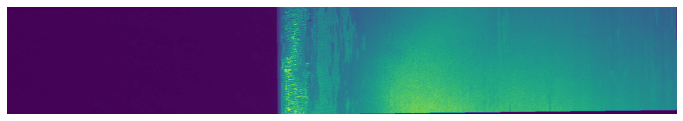

In [12]:
# testing: dataloader

for step, data in enumerate(train_loader):
    b_x = Variable(data['image'])
    b_y = Variable(data['label'])

    plt.figure(figsize=(12,4))
    plt.axis('off')
    plt.imshow(b_x[0].detach().numpy().squeeze()) # Always use .detach() instead of .data which will be expired
    print(b_y[0].detach().numpy())
    break

## 3) Model<a class="anchor" id="3"></a>

In [13]:
class ResBock(nn.Module):
    # conv_block: Conv => BN => ReLu => (MaxPool)
    def conv_block(self, in_channels, out_channels, pool=False):
        layers =    [nn.Conv2d(
                        in_channels,             # no. of layers of pervious layer
                        out_channels,            # n_filters
                        kernel_size=3,           # filter size (3/5)
                        stride=1,                # filter movement/step
                        padding=1                # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1 (1/2)
                    ), 
                    nn.BatchNorm2d(num_features=out_channels),   # Normally, num_features = no. of layers of pervious layer
                    nn.ReLU(inplace=True)        # inplace=True to save memory
                    ]
        if pool: layers.append(nn.MaxPool2d(kernel_size=2, stride=2))   # width/2
        return nn.Sequential(*layers)
        
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = self.conv_block(in_channels, out_channels, pool=False)
        self.conv2 = self.conv_block(out_channels, out_channels, pool=False)
        self.convRes = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.convRes(identity) + x         # where Resnet happens here
        x = self.relu(x)
        return x
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = ResBock(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super().__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = ResBock(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class FirstHalfUNet(nn.Module):
    def __init__(self, in_channels, out_classes=4):
        super().__init__()
        # BN first
        self.bn_input = nn.BatchNorm2d(1)
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 16)
        self.down_conv2 = DownBlock(16, 32)
        self.down_conv3 = DownBlock(32, 64)
        self.down_conv4 = DownBlock(64, 128)
        # Bottleneck
        self.double_conv = ResBock(128, 256)
        # Dense Layer
        self.fc1 = nn.Sequential(
            nn.Linear(256*16*100, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, out_classes),
            nn.BatchNorm1d(out_classes),
            nn.Sigmoid()
        )

        # # Upsampling Path
        # self.up_sample_mode = up_sample_mode
        # self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        # self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        # self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        # self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # # Final Convolution
        # self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x = self.bn_input(x)            # (batch_size,  1, 256, 1600)
        x, _ = self.down_conv1(x)       # (batch_size, 64, 128, 800)
        x, _ = self.down_conv2(x)       # (batch_size, 128, 64, 400)
        x, _ = self.down_conv3(x)       # (batch_size, 256, 32, 200)
        x, _ = self.down_conv4(x)       # (batch_size, 512, 16, 100)
        x = self.double_conv(x)         # (batch_size, 1024, 16, 100)
        x = x.view(x.size(0), -1)       # (batch_size, 1024*16*100)   cannot use flatten here which will be (batch_size*256*16*16)
        x = self.fc1(x)                 # (batch_size, 1024)
        out = self.fc2(x)               # (batch_size, 4)
        return out.float()              # sigmoid [0 1]: return a probabilty of each class
        # x = self.up_conv4(x, skip4_out)
        # x = self.up_conv3(x, skip3_out)
        # x = self.up_conv2(x, skip2_out)
        # x = self.up_conv1(x, skip1_out)
        # x = self.conv_last(x)
        # return x

In [17]:
model = FirstHalfUNet(in_channels=1, out_classes=4).to(device)
print(model)

FirstHalfUNet(
  (bn_input): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (down_conv1): DownBlock(
    (double_conv): ResBock(
      (conv1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (convRes): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): ResBock(
      (conv1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

## 4) Training<a class="anchor" id="4"></a>

In [14]:
def accuracy(prob, labels):
    '''
        Calculate the accuracy (= sum(no. of sample that prediction is fully correct)/batch_size) 

        Args:
            prob: a batch of predictions in probability from model
            labels: a batch of labels from data loader
    '''
    preds = (prob>0.5).float()
    return (torch.tensor(((labels==preds).sum(axis=1)==4).sum() / len(preds))).item()

In [15]:
# Train the model
def fit(EPOCHS, LR, model, train_loader, val_loader, device):

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_func = nn.BCELoss()    # binary classification/multi-label(one-hotted): BCELoss/BCEWithLogitsLoss
                                # BCEWithLogitsLoss = BCELoss + Sigmoid (use this if output does not have sigmoid)
                                # multi-class: nn.CrossEntropyLoss()

    total_train_step = len(train_loader)
    total_val_step = len(val_loader)
    history = []

    for epoch in range(EPOCHS):
        # Training Phase
        train_losses = []
        model.train()
        for step, batch in enumerate(tqdm(train_loader)):
            images = Variable(batch['image']).to(device)
            labels = Variable(batch['label']).to(device)
            
            preds_prob = model(images)               # forward propagation
            loss = loss_func(preds_prob, labels)

            train_losses.append(loss.item())
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # update weights of model by applying gradients
            optimizer.zero_grad()               # clear gradients for this training step

            # Print step_train_loss every 500 steps
            if (step+1) % 500 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], step_train_loss: {:.4f}' 
                    .format(epoch+1, EPOCHS, step+1, total_train_step, loss.item()))
        
        # Validation phase
        val_losses = []
        val_acces = []
        model.eval()                            # model.eval(): stop BN & dropout
        with torch.no_grad():                   # torch.no_grad(): stop back prop
            for step, batch in enumerate(tqdm(val_loader)):
                images = Variable(batch['image']).to(device)
                labels = Variable(batch['label']).to(device)

                preds_prob = model(images)                      
                loss = loss_func(preds_prob, labels)

                val_losses.append(loss.item())
                acc = accuracy(preds_prob, labels)
                val_acces.append(acc)

                # Print step_loss & step_accuracy every 200 steps
                if (step+1) % 200 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], step_val_loss: {:.4f}, step_val_acc: {:.4f}' 
                        .format(epoch+1, EPOCHS, step+1, total_val_step, loss.item(), acc))
        
        # At the end of each epoch
        epoch_result = {
            'epoch': epoch+1,
            'train_loss': np.array(train_losses).mean(),
            'val_loss': np.array(val_losses).mean(),
            'val_acc': np.array(val_acces).mean()
        }
        # Print step_loss & step_accuracy every 500 steps
        print ('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}' 
            .format(epoch_result['epoch'], EPOCHS, epoch_result['train_loss'], epoch_result['val_loss'], epoch_result['val_acc']))
        history.append(epoch_result)
    return pd.DataFrame(history)

In [16]:
%env max_split_size_mb=10000
def load_model_or_train_model (load: bool, load_file_date=None):
    global EPOCHS, LR, model, train_loader, val_loader, device

    model_dir = '..\saved/models/'
    hist_dir = '..\saved/log/'

    if load==False:
        model = FirstHalfUNet(in_channels=1, out_classes=4).to(device)
        train_loader = Data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = Data.DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)
        print('Start Training...')
        hist = fit(EPOCHS, LR, model, train_loader, val_loader, device)                         # train model
        print('Training Completed')

        today_str = date.today().strftime("%Y%m%d")
        torch.save(model, os.path.join(model_dir, f'model_{today_str}.pkl'))                    # save entire model
        torch.save(model.state_dict(), os.path.join(model_dir, f'model_para_{today_str}.pkl'))  # save only the parameters
        print('Model Saved')
        
        hist.to_csv(os.path.join(hist_dir, f'hist_{today_str}.csv'), index=False)               # save history
        print('History Saved')
    else:
        try:
            model = torch.load(os.path.join(model_dir, f'model_{load_file_date}.pkl'), map_location=device)     # Load entire model
            print("Model Loaded")
        except:
            try:
                model.load_state_dict(torch.load(os.path.join(model_dir, f'model_para_{load_file_date}.pkl')))  # Load model para
                print("Model Loaded")
            except:
                print('No such model')
        finally:
            try:
                hist = pd.read_csv(os.path.join(hist_dir, f'hist_{load_file_date}.csv'))        # Load history
                print("History Loaded")
            except:
                print('No such history')
    
    return hist

torch.cuda.empty_cache()
load_model_or_train_model(load=False)   # Train model
# hist = load_model_or_train_model(load=True, load_file_date='20220328')   # Load model
        

env: max_split_size_mb=10000
Start Training...


  0%|          | 4/2666 [03:56<59:56:38, 81.07s/it]

## 4) Evaluation<a class="anchor" id="5"></a>

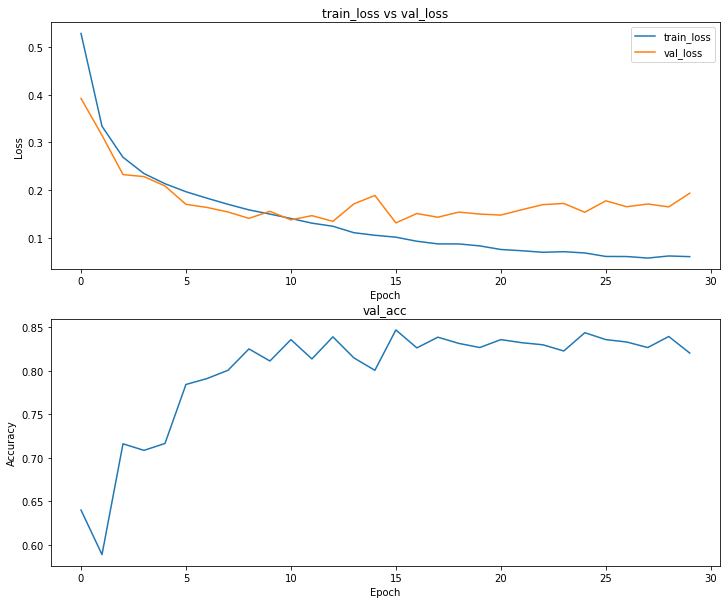

In [19]:
# Plot train_loss, val_loss, val_acc
fig, axs = plt.subplots(2,1, figsize=(12,10))
axs[0].set_title("train_loss vs val_loss")
axs[0].plot(hist['train_loss'])
axs[0].plot(hist['val_loss'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['train_loss', 'val_loss'], loc='upper right')

axs[1].set_title("val_acc")
axs[1].plot(hist['val_acc'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
plt.show()

In [20]:
# Confusion Matrix (Validation set)
# Validation phase
val_loader = Data.DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)
total_val_step = len(val_loader)
val_labels = []
val_preds = []

model.eval()
with torch.no_grad():
    for step, batch in enumerate(tqdm(val_loader)):
        images = Variable(batch['image']).to(device)
        labels = Variable(batch['label']).to(device)
        val_labels.extend(labels.cpu().detach().tolist())

        preds_prob = model(images)
        preds = (preds_prob>0.5).float()
        val_preds.extend(preds.cpu().detach().tolist())
val_labels =np.array(val_labels)
val_preds = np.array(val_preds)

100%|██████████| 629/629 [02:04<00:00,  5.06it/s]


In [22]:
val_preds

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [23]:
import sklearn.metrics as skm

cm = skm.multilabel_confusion_matrix(val_labels, val_preds)
print(cm)
print(skm.classification_report(val_labels, val_preds, target_names=['Class 1','Class 2','Class 3','Class 4']))

[[[2313   18]
  [  26  157]]

 [[2461   10]
  [   6   37]]

 [[1386   32]
  [  67 1029]]

 [[2345    2]
  [  38  129]]]
              precision    recall  f1-score   support

     Class 1       0.90      0.86      0.88       183
     Class 2       0.79      0.86      0.82        43
     Class 3       0.97      0.94      0.95      1096
     Class 4       0.98      0.77      0.87       167

   micro avg       0.96      0.91      0.93      1489
   macro avg       0.91      0.86      0.88      1489
weighted avg       0.96      0.91      0.93      1489
 samples avg       0.51      0.51      0.51      1489

